In [ ]:
!pip -q install -U transformers datasets accelerate scikit-learn
import numpy as np
import pandas as pd
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 78.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 515.2/515.2 kB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 536.6/536.6 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.6/47.6 MB 17.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jan 27 02:16:14 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              9W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import pandas as pd


df = pd.read_csv("/content/drive/MyDrive/MSDS_marketing_text_analytics/master_files/fake_job_postings.csv")  # reads first sheet by default
df.head()


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


In [ ]:
print(df.shape)

(17880, 18)


## Data Understanding & Preprocessing

In [ ]:
df['fraudulent'].describe()

,fraudulent
count,17880.000000
mean,0.048434
std,0.214688
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


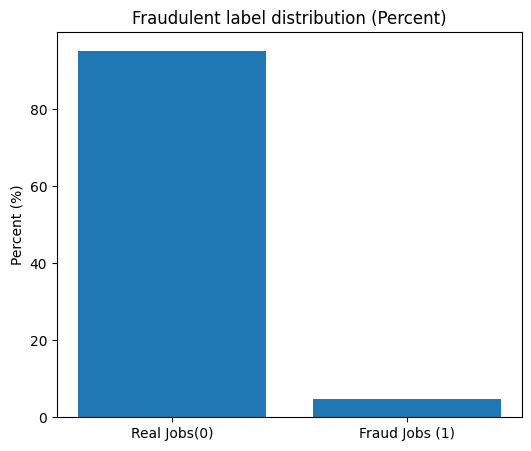

In [ ]:
import matplotlib.pyplot as plt

counts = df["fraudulent"].value_counts().sort_index()
pct_fraud = df["fraudulent"].mean() * 100

plt.figure(figsize=(6,5))
plt.bar(["Real Jobs(0)", "Fraud Jobs (1)"], [(1 - df["fraudulent"].mean())*100, df["fraudulent"].mean()*100])
plt.title("Fraudulent label distribution (Percent)")
plt.ylabel("Percent (%)")
plt.show()


The dataset has very few Fraud jobs compared to real jobs. Out of every 100 jobs, only about 5 are labeled fraud and the other 95 are labeled Real Jobs. Because the data is so uneven, a model can look like it’s doing well just by guessing real jobs most of the time, even if it barely catches any of the fraud jobs. That’s why accuracy by itself can be misleading.This dataset is clearly unbalanced.

In [ ]:
sample_amount =  len(df[df["fraudulent"] == 1])

fraudulent = df[df['fraudulent'] == 1]
real_job = df[df['fraudulent'] == 0].sample(n=sample_amount)
print(sample_amount)

review_sample = pd.concat([fraudulent,real_job])
len(review_sample)

866


1732

The syntax above first counts how many fraudulent jobs the dataset has by filtering the dataset to rows where fraudulent == 1 and taking the length, then it stores all of those fraudulent rows in a fraudulent dataset. After that, it takes the much larger **real job** group (real_job == 0) and randomly picks the same number of rows (sample_amount) from it to create real_job. The reason for doing this is to make a more **balanced dataset** (roughly 50/50 fraudulent vs real job) so the model doesn’t just learn to guess real job all the time because that class is much more common.

Then I append the two datasets, fraudulent and real_job into one new dataset called review_sample. The goal is to create a balanced dataset with about the same number of fraudulent and real job descriptions. len(review_sample), prints how many total rows are now in that combined dataset.

In [ ]:
review_sample.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
98,99,IC&E Technician,"US, , Stocton, CA",Oil & Energy,95000-115000,...,"IC&amp;E Technician | Bakersfield, CA Mt. Poso...","QualificationsKnowledge, Skills &amp; Abilitie...",BENEFITSWhat is offered:Competitive compensati...,0,1,1,Full-time,Mid-Senior level,High School or equivalent,Oil & Energy,Other,1
144,145,Forward Cap.,NaN,NaN,NaN,NaN,The group has raised a fund for the purchase o...,NaN,NaN,0,0,0,NaN,NaN,NaN,NaN,NaN,1
173,174,Technician Instrument & Controls,US,Power Plant & Energy,NaN,Edison International and Refined Resources hav...,Technician Instrument &amp; ControlsLocation D...,JOB QUALIFICATIONS-Ability to understand proce...,"we are a team of almost 8,000 employees who he...",0,1,1,Full-time,Mid-Senior level,Certification,Electrical/Electronic Manufacturing,Other,1
180,181,Sales Executive,"PK, SD, Karachi",Sales,NaN,NaN,Sales Executive,Sales Executive,Sales Executive,0,0,0,NaN,NaN,NaN,NaN,Sales,1
215,216,IC&E Technician Mt Poso,"US, CA, Bakersfield, CA / Mt. Poso",Oil & Energy,95000-115000,...,"IC&amp;E Technician | Bakersfield, CA Mt. Poso...","QualificationsKnowledge, Skills &amp; Abiliti...",BENEFITSWhat is offered:Competitive compensati...,0,1,1,Full-time,Mid-Senior level,High School or equivalent,Oil & Energy,Other,1


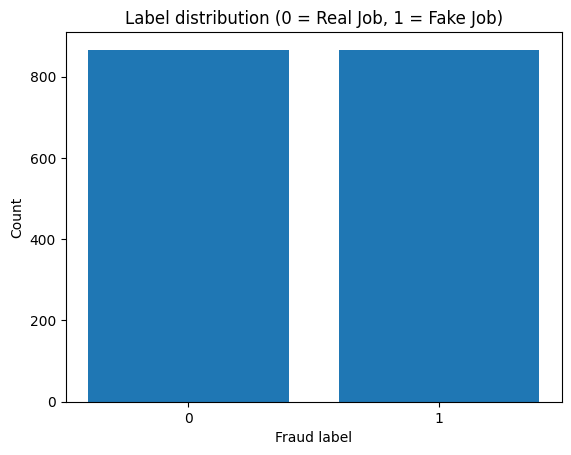

fraudulent
0    866
1    866
Name: count, dtype: int64
Percent fraud (1): 50.0 %


In [ ]:
import matplotlib.pyplot as plt

counts = review_sample["fraudulent"].value_counts().sort_index()

plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.title("Label distribution (0 = Real Job, 1 = Fake Job)")
plt.xlabel("Fraud label")
plt.ylabel("Count")
plt.show()

print(counts)
print("Percent fraud (1):", round(100 * counts.get(1, 0) / counts.sum(), 2), "%")

As you can see the plot shows that we are now working with a balanced dataset.

In [ ]:
review_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1732 entries, 98 to 13782
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               1732 non-null   int64 
 1   title                1732 non-null   object
 2   location             1700 non-null   object
 3   department           642 non-null    object
 4   salary_range         361 non-null    object
 5   company_profile      993 non-null    object
 6   description          1731 non-null   object
 7   requirements         1448 non-null   object
 8   benefits             1040 non-null   object
 9   telecommuting        1732 non-null   int64 
 10  has_company_logo     1732 non-null   int64 
 11  has_questions        1732 non-null   int64 
 12  employment_type      1321 non-null   object
 13  required_experience  951 non-null    object
 14  required_education   898 non-null    object
 15  industry             1224 non-null   object
 16  function 

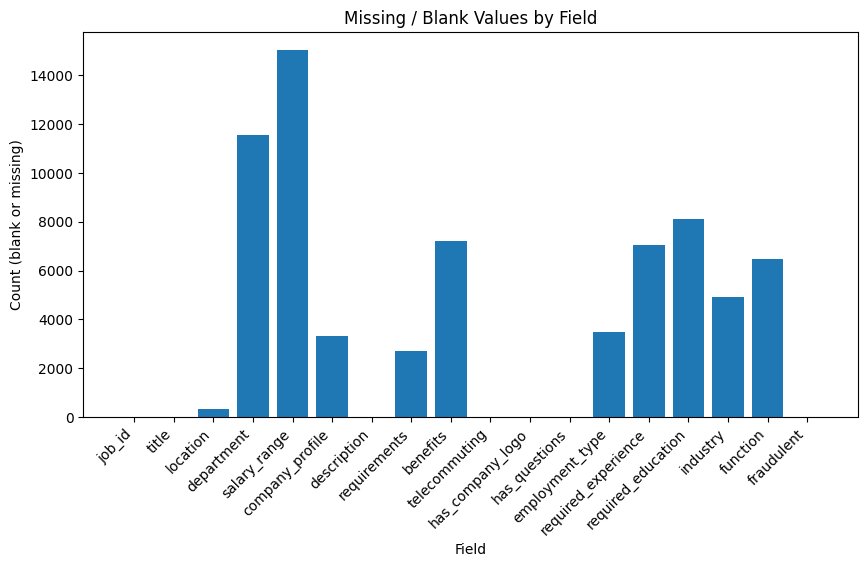

In [ ]:
import matplotlib.pyplot as plt

cols = list(review_sample.columns)

missing_counts = []
for c in cols:
    s = df[c]
    blank_or_missing = s.isna() | (s.astype(str).str.strip() == "")
    missing_counts.append(blank_or_missing.sum())

plt.figure(figsize=(10,5))
plt.bar(cols, missing_counts)
plt.title("Missing / Blank Values by Field")
plt.xlabel("Field")
plt.ylabel("Count (blank or missing)")
plt.xticks(rotation=45, ha="right")
plt.show()

Even though the dataset has no “null” values, this chart shows that some rows still have empty text fields, especially salary range (the most) and department, which matters because blank text gives the model less information to learn from.

The dataset has a lot of missing (blank) values in many of the columns. Before I can analyze the data or train a model, I need to handle those blanks so they don’t cause errors or mess up the results. For text-based columns(requirements,benefits), I filled missing values with an  empty string '', which basically means **no text was provided.** For categorical columns(department, industry, function, etc.), I filled missing values with **Unspecified**, so the missing entries become a clear category instead of being left blank. This lets me keep more rows of data and keeps the dataset consistent.

In [ ]:
 #  Fill ALL missing values with empty string
review_sample = review_sample.fillna('')

#  For specific categorical columns, replace empty '' with "Unspecified"
cat_cols = ['department', 'industry', 'function', 'location','employment_type',
            'required_experience','required_education']  # <- change to your categorical column names
review_sample[cat_cols] = review_sample[cat_cols].replace('', 'Unspecified')


In [ ]:
# empty strings exactly
print("Empty '' counts:\n", (review_sample[cat_cols] == '').sum())

# whitespace-only (like '   ')
print("\nWhitespace-only counts:\n",
      review_sample[cat_cols].astype(str).apply(lambda s: s.str.strip().eq('')).sum())

print("\nUnspecified counts:\n", (review_sample[cat_cols] == 'Unspecified').sum())



Empty '' counts:
 department             0
industry               0
function               0
location               0
employment_type        0
required_experience    0
required_education     0
dtype: int64

Whitespace-only counts:
 department             0
industry               0
function               0
location               0
employment_type        0
required_experience    0
required_education     0
dtype: int64

Unspecified counts:
 department             1090
industry                508
function                649
location                 32
employment_type         411
required_experience     781
required_education      965
dtype: int64


In [ ]:
# correct the whitespace
col = 'department'
review_sample[col] = review_sample[col].astype(str).str.strip().replace('', 'Unspecified')

#check
(review_sample[cat_cols].astype(str).apply(lambda s: s.str.strip().eq('')).sum())



,0
department,0
industry,0
function,0
location,0
employment_type,0
required_experience,0
required_education,0


## Exploratory Data Analysis (EDA) on Numerical and Categorical

In [ ]:
# Split the "location" column into 3 new columns: country, state, city
review_sample[['country', 'state', 'city']] = (
    review_sample['location']                         # take the original location column (ex: "US, CA, Los Angeles")
      .astype(str)                                    # make sure every value is treated as a string
      .str.split(',', n=2, expand=True)               # split on commas into up to 3 parts (country/state/city) and return as columns
      .apply(lambda col: col.str.strip())             # remove extra spaces from each part (ex: " CA" -> "CA")
)

# (optional) fill anything missing after the split
review_sample[['country','state','city']] = review_sample[['country','state','city']].fillna('Unspecified')

# Fix any blank/whitespace-only values in state (this removes the unlabeled bar)
review_sample['state'] = (
    review_sample['state']                            # take the state column
    .astype(str)                                      # ensure it's a string
    .str.strip()                                      # remove leading/trailing spaces
)
review_sample.loc[review_sample['state'] == '', 'state'] = 'Unspecified'  # replace empty state with Unspecified

# replace only "Not Applicable" with "Experience Unavailable"
review_sample['required_experience'] = (                 # update the required_experience column in review_sample
    review_sample['required_experience']                 # start with the existing values
    .replace('Not Applicable', 'Experience Unavailable') # change just this one category label
)

# check the counts to confirm the change happened
review_sample['required_experience'].value_counts()      # show updated category counts



,count
required_experience,
Unspecified,781
Entry level,314
Mid-Senior level,294
Associate,122
Experience Unavailable,119
Director,44
Internship,35
Executive,23


I split the location column into three cleaner columns, **country, state, and city** by breaking the text apart at the commas and trimming extra spaces. The purpose is to make EDA easier, so I can compare fraud vs non-fraud patterns by country/state/city instead of dealing with one messy combined field.

In [ ]:
review_sample.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country,state,city
98,99,IC&E Technician,"US, , Stocton, CA",Oil & Energy,95000-115000,...,"IC&amp;E Technician | Bakersfield, CA Mt. Poso...","QualificationsKnowledge, Skills &amp; Abilitie...",BENEFITSWhat is offered:Competitive compensati...,0,...,1,Full-time,Mid-Senior level,High School or equivalent,Oil & Energy,Other,1,US,Unspecified,"Stocton, CA"
144,145,Forward Cap.,Unspecified,Unspecified,,,The group has raised a fund for the purchase o...,,,0,...,0,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,1,Unspecified,Unspecified,Unspecified
173,174,Technician Instrument & Controls,US,Power Plant & Energy,,Edison International and Refined Resources hav...,Technician Instrument &amp; ControlsLocation D...,JOB QUALIFICATIONS-Ability to understand proce...,"we are a team of almost 8,000 employees who he...",0,...,1,Full-time,Mid-Senior level,Certification,Electrical/Electronic Manufacturing,Other,1,US,Unspecified,Unspecified
180,181,Sales Executive,"PK, SD, Karachi",Sales,,,Sales Executive,Sales Executive,Sales Executive,0,...,0,Unspecified,Unspecified,Unspecified,Unspecified,Sales,1,PK,SD,Karachi
215,216,IC&E Technician Mt Poso,"US, CA, Bakersfield, CA / Mt. Poso",Oil & Energy,95000-115000,...,"IC&amp;E Technician | Bakersfield, CA Mt. Poso...","QualificationsKnowledge, Skills &amp; Abiliti...",BENEFITSWhat is offered:Competitive compensati...,0,...,1,Full-time,Mid-Senior level,High School or equivalent,Oil & Energy,Other,1,US,CA,"Bakersfield, CA / Mt. Poso"


In [ ]:
#Picking the best categorical/binary columns that can predict fraud.

# import pandas for tables
import pandas as pd

# import chi-square test
from scipy.stats import chi2_contingency

# set your label column
y_col = 'fraudulent'                                                      # 0=real, 1=fake

# list the categorical/binary columns you want to test (edit this list)
cat_cols = ['employment_type', 'required_experience', 'required_education',
            'state', 'industry', 'function', 'department',
            'telecommuting', 'has_company_logo', 'has_questions']         # examples

# create a list to store results
results = []                                                              # will store (col, p, cramer_v)

# loop through each column and run chi-square
for c in cat_cols:                                                        # go one column at a time
    tmp = review_sample[[c, y_col]].copy()                                # take the feature + label
    tmp[c] = tmp[c].fillna('Unspecified').astype(str).str.strip()         # fill missing + clean whitespace

    table = pd.crosstab(tmp[c], tmp[y_col])                               # contingency table: categories x fraud label

    if table.shape[0] < 2 or table.shape[1] < 2:                          # need at least 2 categories and both labels
        continue                                                          # skip if test is not valid

    chi2, p, dof, expected = chi2_contingency(table)                      # run chi-square test

    n = table.to_numpy().sum()                                            # total sample size
    r, k = table.shape                                                   # number of rows and columns
    cramer_v = (chi2 / (n * (min(r - 1, k - 1)))) ** 0.5                  # Cramér’s V effect size (0 to 1)

    results.append((c, p, cramer_v))                                      # store results

# sort by strongest effect size (Cramér’s V) first
results_sorted = sorted(results, key=lambda x: x[2], reverse=True)         # rank by V descending

# print results nicely
print("Column".ljust(22), "p-value".ljust(14), "Cramer's V")              # header
for c, p, v in results_sorted:                                            # print each result
    print(c.ljust(22), f"{p:.3e}".ljust(14), f"{v:.3f}")                  # formatted output


Column                 p-value        Cramer's V
industry               4.420e-58      0.545
department             4.092e-20      0.528
state                  3.007e-29      0.483
has_company_logo       3.560e-89      0.481
function               9.650e-35      0.380
required_education     1.538e-25      0.286
has_questions          6.696e-18      0.207
required_experience    3.753e-09      0.175
employment_type        8.127e-08      0.154
telecommuting          2.675e-02      0.053


In [ ]:
# list the columns you want to sanity-check for messiness
check_cols = ['department', 'industry', 'has_company_logo']                         # columns to inspect

# loop through each column and print quick stats
for col in check_cols:                                                   # go column by column
    s = review_sample[col].fillna('Unspecified').astype(str).str.strip() # clean the column values
    counts = s.value_counts()                                            # count each category
    print("\nColumn:", col)                                              # print column name
    print("Unique categories:", s.nunique())                              # number of unique labels
    print("Unspecified share:", round((s == 'Unspecified').mean(), 3))    # how missing it is
    print("Categories with <=5 rows:", int((counts <= 5).sum()))          # how many rare labels
    print("Top 10 values:\n", counts.head(10))                            # show top categories



Column: department
Unique categories: 231
Unspecified share: 0.629
Categories with <=5 rows: 214
Top 10 values:
 department
Unspecified               1090
Engineering                 79
Sales                       42
Information Technology      30
Oil & Energy                28
Clerical                    27
Marketing                   25
Administrative              16
Customer Service            16
IT                          12
Name: count, dtype: int64

Column: industry
Unique categories: 98
Unspecified share: 0.293
Categories with <=5 rows: 59
Top 10 values:
 industry
Unspecified                            508
Information Technology and Services    131
Oil & Energy                           116
Financial Services                      83
Marketing and Advertising               80
Computer Software                       76
Hospital & Health Care                  72
Accounting                              64
Internet                                51
Education Management             

In [ ]:
# set a minimum count to keep a category label (everything else becomes "Other")
min_count = 30
# group rare industry categories into "Other"
ind_counts = review_sample['industry'].value_counts()                   # count each industry
keep_ind = ind_counts[ind_counts >= min_count].index                    # industries to keep
review_sample['industry_grp'] = review_sample['industry'].where(        # create grouped industry column
    review_sample['industry'].isin(keep_ind), 'Other'                   # rare -> Other
)

I ran this check to see which non-text columns are clean and reliable enough to help predict fake vs real jobs. **has_company_logo** is great because it only has two values (0/1) and no missing data, so it’s consistent. **industry** looks usable, but it has a lot of different labels and some rare ones. I  grouped the rare industries into an “Other” bucket or keep only the most common categories. I’m not using department as-is because it’s extremely messy: most rows are Unspecified and almost all the other department labels show up only a handful of times, which can add noise and make the model learn unstable patterns instead of real signals.

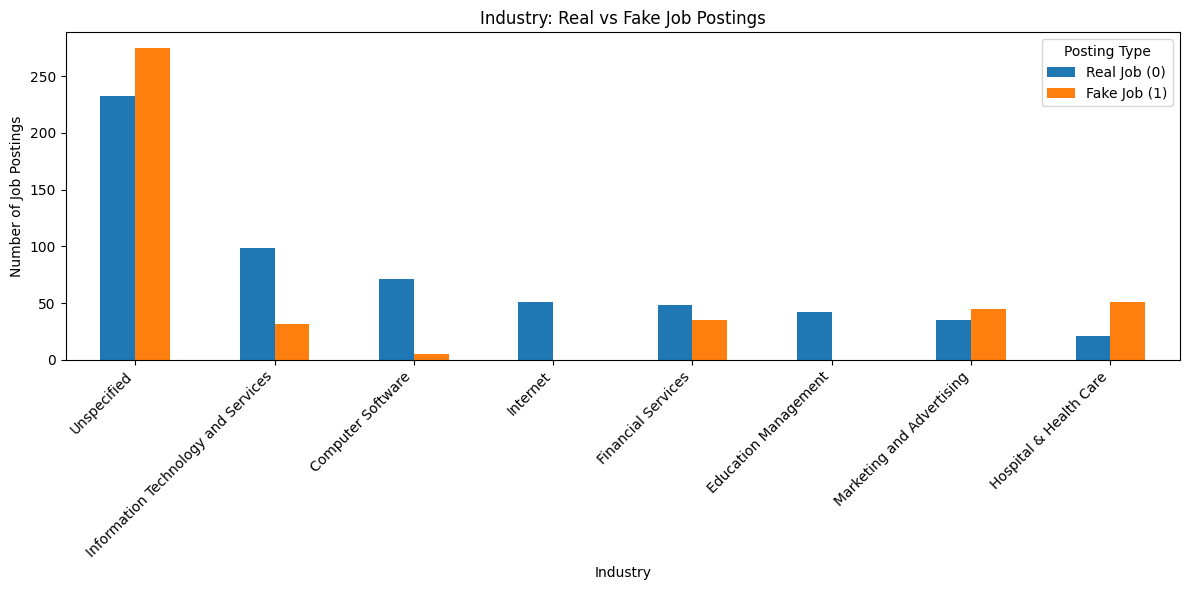

In [ ]:
# group by industry + fraud label (0=real, 1=fake), then count how many rows in each group
industry_counts = (
    review_sample
    .groupby(['industry', 'fraudulent'])
    .size()
    .unstack(fill_value=0)
)

# rename the columns so the legend shows friendly labels
industry_counts = industry_counts.rename(columns={0: 'Real Job (0)', 1: 'Fake Job (1)'})  # rename 0/1 columns

# sort industry by highest real jobs first (then fake jobs)
top_industrys = (
    industry_counts
    .sort_values(by=['Real Job (0)', 'Fake Job (1)'], ascending=False)
    .head(8)
)

# plot side-by-side bars so real vs fake have different colors automatically
ax = top_industrys.plot(kind='bar', figsize=(12, 6))        # grouped bar chart

# set the chart title
plt.title('Industry: Real vs Fake Job Postings')

# label the x-axis
plt.xlabel('Industry')

# label the y-axis
plt.ylabel('Number of Job Postings')                     # y label

# rotate x labels so they fit
plt.xticks(rotation=45, ha='right')                      # rotate ticks

# show the legend (real vs fake)
plt.legend(title='Posting Type')                         # legend title

# tighten spacing so labels don’t get cut off
plt.tight_layout()                                       # tight layout

# display the plot
plt.show()                                               # show plot

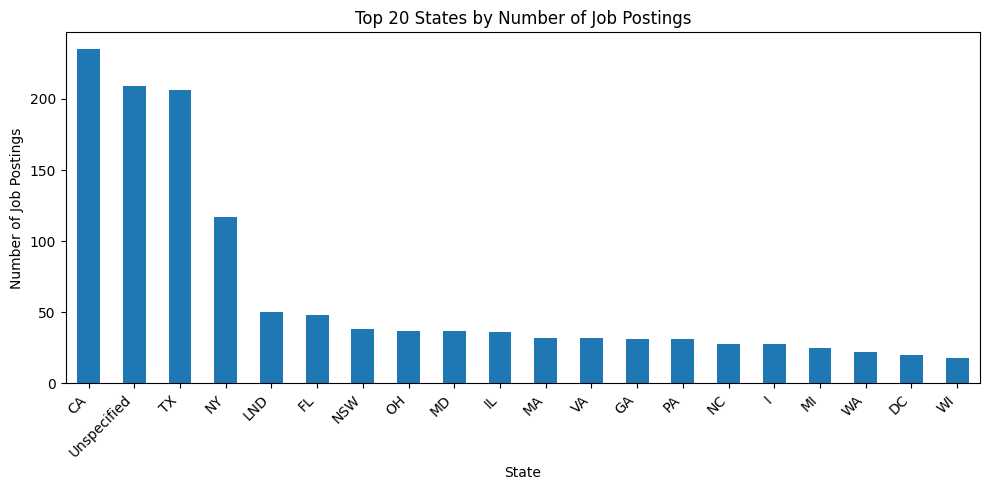

In [ ]:
# Bar chart: job postings per state (Top 20)

# count how many rows (job postings) each state has, then keep the top 20
counts = review_sample['state'].value_counts().head(20)  # top 20 states by total postings

# create a figure and set its size (w, h)
plt.figure(figsize=(10, 5))                              # set figure size

# draw a bar chart from the counts series
counts.plot(kind='bar')                                  # bar chart

# add a title to the chart
plt.title('Top 20 States by Number of Job Postings')     # title

# label the x-axis
plt.xlabel('State')                                      # x label

# label the y-axis
plt.ylabel('Number of Job Postings')                     # y label

# rotate x labels so they don’t overlap, and align them nicely
plt.xticks(rotation=45, ha='right')                      # rotate ticks

# tighten spacing so labels fit cleanly
plt.tight_layout()                                       # tight layout

# display the plot
plt.show()                                               # show plot


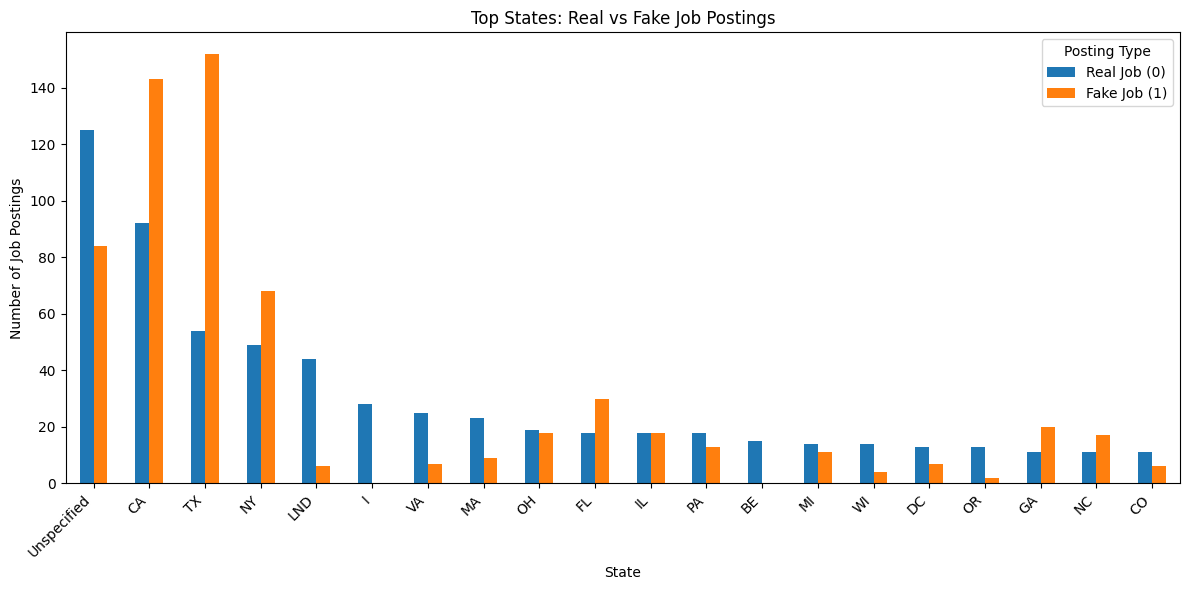

In [ ]:
# group by state + fraud label (0=real, 1=fake), then count how many rows in each group
state_counts = (
    review_sample
    .groupby(['state', 'fraudulent'])                     # group rows by state and fraudulent label
    .size()                                               # count rows per group
    .unstack(fill_value=0)                                # convert label values into columns, fill missing with 0
)

# rename the columns so the legend shows friendly labels
state_counts = state_counts.rename(columns={0: 'Real Job (0)', 1: 'Fake Job (1)'})  # rename 0/1 columns

# sort states by highest real jobs first (then fake jobs), and keep top 20
top_states = (
    state_counts
    .sort_values(by=['Real Job (0)', 'Fake Job (1)'], ascending=False)  # sort
    .head(20)                                                           # top 20
)

# plot side-by-side bars so real vs fake have different colors automatically
ax = top_states.plot(kind='bar', figsize=(12, 6))        # grouped bar chart

# set the chart title
plt.title('Top States: Real vs Fake Job Postings')        # title

# label the x-axis
plt.xlabel('State')                                      # x label

# label the y-axis
plt.ylabel('Number of Job Postings')                     # y label

# rotate x labels so they fit
plt.xticks(rotation=45, ha='right')                      # rotate ticks

# show the legend (real vs fake)
plt.legend(title='Posting Type')                         # legend title

# tighten spacing so labels don’t get cut off
plt.tight_layout()                                       # tight layout

# display the plot
plt.show()                                               # show plot

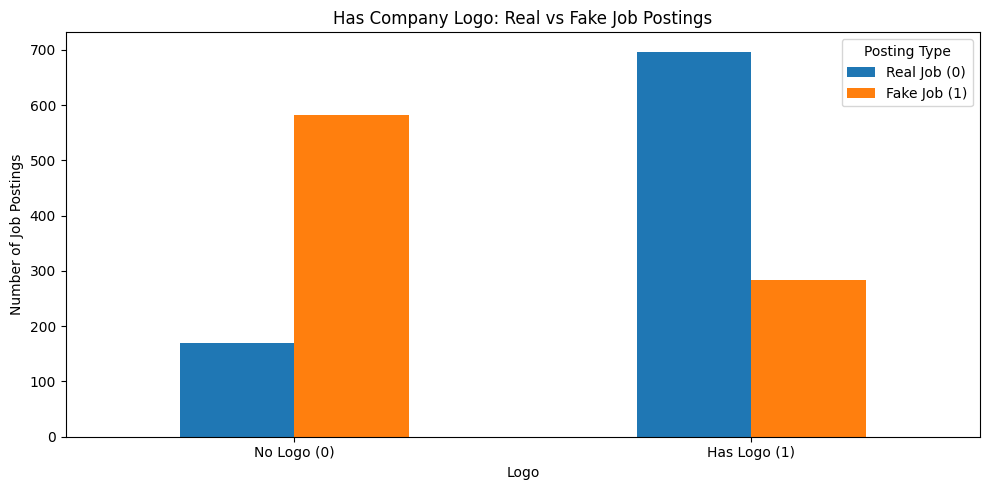

In [ ]:
# group by has_company_logo + fraud label (0=real, 1=fake), then count how many rows in each group
logo_counts = (
    review_sample
    .groupby(['has_company_logo', 'fraudulent'])
    .size()
    .unstack(fill_value=0)
)

# rename the columns so the legend shows friendly labels
logo_counts =logo_counts.rename(columns={0: 'Real Job (0)', 1: 'Fake Job (1)'})  # rename 0/1 columns

# rename the index (0/1) so x-axis shows "No Logo" and "Has Logo"
logo_counts = logo_counts.rename(index={0: 'No Logo (0)', 1: 'Has Logo (1)'})     # rename x-axis categories

# ensure the x-axis order is 0 then 1 (No Logo first, Has Logo second)
logo_counts = logo_counts.reindex(['No Logo (0)', 'Has Logo (1)'])                # order the bars

# plot side-by-side bars so real vs fake have different colors automatically
ax = logo_counts.plot(kind='bar', figsize=(10, 5))                                # grouped bar chart

# set the chart title
plt.title('Has Company Logo: Real vs Fake Job Postings')                          # title

# label the x-axis
plt.xlabel('Logo')                                                                # x label

# label the y-axis
plt.ylabel('Number of Job Postings')                                              # y label

# rotate x labels so they fit
plt.xticks(rotation=0)                                                            # keep labels horizontal

# show the legend (real vs fake)
plt.legend(title='Posting Type')                                                  # legend title

# tighten spacing so labels don’t get cut off
plt.tight_layout()                                                                # tight layout

# display the plot
plt.show()

In [ ]:
review_sample.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,employment_type,required_experience,required_education,industry,function,fraudulent,country,state,city,industry_grp
98,99,IC&E Technician,"US, , Stocton, CA",Oil & Energy,95000-115000,...,"IC&amp;E Technician | Bakersfield, CA Mt. Poso...","QualificationsKnowledge, Skills &amp; Abilitie...",BENEFITSWhat is offered:Competitive compensati...,0,...,Full-time,Mid-Senior level,High School or equivalent,Oil & Energy,Other,1,US,Unspecified,"Stocton, CA",Oil & Energy
144,145,Forward Cap.,Unspecified,Unspecified,,,The group has raised a fund for the purchase o...,,,0,...,Unspecified,Unspecified,Unspecified,Unspecified,Unspecified,1,Unspecified,Unspecified,Unspecified,Unspecified
173,174,Technician Instrument & Controls,US,Power Plant & Energy,,Edison International and Refined Resources hav...,Technician Instrument &amp; ControlsLocation D...,JOB QUALIFICATIONS-Ability to understand proce...,"we are a team of almost 8,000 employees who he...",0,...,Full-time,Mid-Senior level,Certification,Electrical/Electronic Manufacturing,Other,1,US,Unspecified,Unspecified,Other
180,181,Sales Executive,"PK, SD, Karachi",Sales,,,Sales Executive,Sales Executive,Sales Executive,0,...,Unspecified,Unspecified,Unspecified,Unspecified,Sales,1,PK,SD,Karachi,Unspecified
215,216,IC&E Technician Mt Poso,"US, CA, Bakersfield, CA / Mt. Poso",Oil & Energy,95000-115000,...,"IC&amp;E Technician | Bakersfield, CA Mt. Poso...","QualificationsKnowledge, Skills &amp; Abiliti...",BENEFITSWhat is offered:Competitive compensati...,0,...,Full-time,Mid-Senior level,High School or equivalent,Oil & Energy,Other,1,US,CA,"Bakersfield, CA / Mt. Poso",Oil & Energy


In [ ]:
# import numpy for simple math
import numpy as np

# import train/test split
from sklearn.model_selection import train_test_split

# import TF-IDF vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

# import logistic regression
from sklearn.linear_model import LogisticRegression

# import F1 score metric
from sklearn.metrics import f1_score

# list the text fields you want to test (edit as needed)
text_fields = ['description', 'requirements', 'benefits', 'company_profile']  # fields to compare

# create empty list to store results
scores = []  # will hold (field, f1) results

# split labels once so every field is tested on the same split
y = review_sample['fraudulent'].astype(int)  # 0=real, 1=fake label column
idx_train, idx_test = train_test_split(      # split row indexes
    review_sample.index,                     # row ids
    test_size=0.2,                           # 20% test
    random_state=42,                         # reproducible
    stratify=y                               # keep class balance
)

# loop through each text field and score it
for col in text_fields:                                           # go field by field
    X = review_sample[col].fillna('').astype(str)                 # get that field as clean text
    X_train = X.loc[idx_train]                                    # training text
    X_test  = X.loc[idx_test]                                     # test text
    y_train = y.loc[idx_train]                                    # training labels
    y_test  = y.loc[idx_test]                                     # test labels

    vec = TfidfVectorizer(max_features=50000, ngram_range=(1,2))  # convert text -> TF-IDF features
    Xtr = vec.fit_transform(X_train)                              # fit on train, transform train
    Xte = vec.transform(X_test)                                   # transform test using same vocab

    clf = LogisticRegression(max_iter=1000)                       # simple baseline classifier
    clf.fit(Xtr, y_train)                                         # train the model

    pred = clf.predict(Xte)                                       # predict on test
    f1 = f1_score(y_test, pred, pos_label=1)                      # F1 for fake jobs (label=1)

    scores.append((col, f1))                                      # store result

# sort best to worst and print
scores_sorted = sorted(scores, key=lambda x: x[1], reverse=True)   # rank by F1
for col, f1 in scores_sorted:                                      # print results
    print(f"{col:15s}  F1(fake=1): {f1:.3f}")                      # show field + score


company_profile  F1(fake=1): 0.905
description      F1(fake=1): 0.869
requirements     F1(fake=1): 0.820
benefits         F1(fake=1): 0.681


In [ ]:
#combining text and categorical text into one column for modelling purposes.

# import matplotlib for plotting
import matplotlib.pyplot as plt

# create combined_text using the 3 text columns (safe even if there are blanks)
review_sample['combined_text'] = (                                         # create/overwrite combined_text
    review_sample['description'].fillna('').astype(str) + ' ' +            # add description text
    review_sample['company_profile'].fillna('').astype(str)                   # add company_profile text
)

# create a working reference to the same dataframe
df = review_sample                                                        # df points to review_sample

# strip leading/trailing spaces from the combined text
df["text"] = df['combined_text'].astype(str).str.strip()                  # clean text

# compute word count by splitting on whitespace and counting tokens
df["wc_text"] = df["text"].str.split().str.len()                          # word count per row

# choose the metadata columns you want to add (edit this list if needed)
meta_cols = ['has_company_logo','state','industry']  # metadata columns

# make sure each metadata column is a clean string (and strip whitespace)
for c in meta_cols:                                                          # loop through each meta column
    review_sample[c] = review_sample[c].fillna('Unspecified').astype(str).str.strip()  # fill + clean

# build meta_text but SKIP "Unspecified" values to keep it short
review_sample['meta_text'] = (                                               # create meta_text column
    review_sample[meta_cols]                                                 # take selected meta columns
    .apply(                                                                 # apply row-wise function
        lambda r: " | ".join([f"{c}:{r[c]}" for c in meta_cols               # build "col:value" pairs
                              if r[c] != 'Unspecified']), axis=1            # skip Unspecified values
    )
)

# cap metadata length so it won’t add too many tokens
review_sample['meta_text'] = review_sample['meta_text'].str.slice(0, 200)    # keep only first 200 chars

# combine your main text with metadata text into final_text for DistilBERT
review_sample['final_text'] = (                                              # create final_text column
    review_sample['combined_text'].fillna('').astype(str) +                  # main combined text
    " [META] " +                                                            # separator token
    review_sample['meta_text'].fillna('').astype(str)                        # appended metadata
)

# quick sanity check: show the first few rows of final_text
review_sample[['combined_text', 'meta_text', 'final_text']].head(3)







,combined_text,meta_text,final_text
98,"IC&amp;E Technician | Bakersfield, CA Mt. Poso...",has_company_logo:1 | industry:Oil & Energy,"IC&amp;E Technician | Bakersfield, CA Mt. Poso..."
144,The group has raised a fund for the purchase o...,has_company_logo:0,The group has raised a fund for the purchase o...
173,Technician Instrument &amp; ControlsLocation D...,has_company_logo:1 | industry:Electrical/Elect...,Technician Instrument &amp; ControlsLocation D...


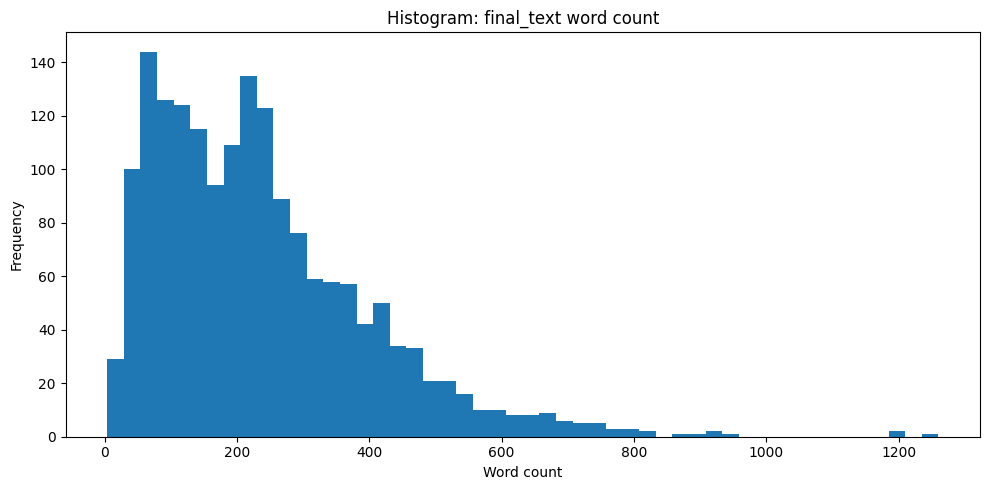

/tmp/ipython-input-1394414729.py:34: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([t0, t1], labels=['Real Job (0)', 'Fake Job (1)'])          # boxplot


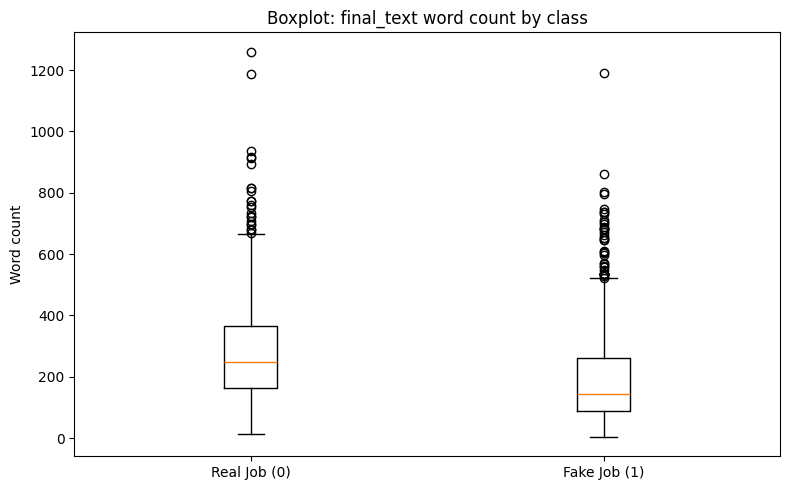

In [ ]:
# import matplotlib for plotting
import matplotlib.pyplot as plt

# set which column you want to analyze (final_text is what you model with)
text_col = 'final_text'                                                # use final_text for plots

# clean the text (strip extra spaces)
df['text2'] = df[text_col].fillna('').astype(str).str.strip()          # clean modeling text

# compute word count
df['wc_text2'] = df['text2'].str.split().str.len()                     # word count per row


# Histogram: word count of final_text


plt.figure(figsize=(10, 5))                                            # create figure
plt.hist(df['wc_text2'], bins=50)                                      # histogram
plt.title('Histogram: final_text word count')                          # title
plt.xlabel('Word count')                                               # x label
plt.ylabel('Frequency')                                                # y label
plt.tight_layout()                                                     # tidy layout
plt.show()                                                             # show plot



# Boxplot: word count by class


t0 = df.loc[df['fraudulent'] == 0, 'wc_text2']                          # real jobs word counts
t1 = df.loc[df['fraudulent'] == 1, 'wc_text2']                          # fake jobs word counts

plt.figure(figsize=(8, 5))                                             # create figure
plt.boxplot([t0, t1], labels=['Real Job (0)', 'Fake Job (1)'])          # boxplot
plt.title('Boxplot: final_text word count by class')                   # title
plt.ylabel('Word count')                                               # y label
plt.tight_layout()                                                     # tidy layout
plt.show()                                                             # show plot


These two plots show how long the combined job-post text (final_text) is, and whether length looks different for real vs fake posts. The histogram shows that most postings are a few hundred words long, but there’s a long tail with some posts that are very long (even over 1,000 words). The boxplot compares lengths by class and shows that real job posts tend to be longer on average than fake ones, though both classes include some very long outliers. The reason you created these plots is to understand the input size before modeling—especially because models like DistilBERT can only read a limited amount of text at once (token limit), so knowing the length distribution helps you choose a reasonable max_length, estimate how much truncation might happen, and decide whether text length might also be a useful signal for classification.

In [ ]:
# install transformers if needed (Colab usually has it, but this is safe)
!pip -q install transformers

# import the tokenizer loader
from transformers import AutoTokenizer

# create a DistilBERT tokenizer (this defines the variable named "tokenizer")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")


#How to check if truncation matters
#Before locking in max_length=128, run:

token_lengths = [len(tokenizer(t)["input_ids"]) for t in review_sample["final_text"]]
import numpy as np
np.percentile(token_lengths, [50, 75, 90, 95, 99])

#If 95% of your examples are <128 tokens, you can safely use 128.
#If many are above that, go with 256.

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (584 > 512). Running this sequence through the model will result in indexing errors


array([ 307.  ,  468.  ,  653.  ,  808.45, 1104.07])

### Exploratory Data Analysis (EDA):

In my EDA, I cleaned and explored key categorical and text fields to see how they relate to fraud. I split the location field into country, state, and city so I could analyze job postings by region. Then I fixed blanks by labeling them as **Unspecified** to avoid missing/empty categories. I created bar charts for **industry**, **state**, and **company logo** to compare the number of real (0) vs fake (1) postings in each group and see which categories had the highest counts. I also tested multiple categorical/binary columns using a **chi-square test** and ranked them with **Cramér’s V** to identify which fields had the strongest relationship with fraud (department, industry, logo, and state). Finally, I combined my main text fields into one column called **final_text**, added selected metadata (logo + industry), and used a histogram and boxplot of word counts to understand text length, spot outliers, and confirm that some postings are long enough to require truncation later when using **DistilBERT**. DistilBERT only supports about **512 tokens** per input, and some of my postings reach **~624 tokens**, so it’s important to tokenize with **truncation=True** (and typically max_length=512) and use **padding to 512**  so every batch is the same size and the model doesn’t throw length errors.

## Deep learning

In [ ]:
!pip -q install -U transformers datasets accelerate scikit-learn

import os
os.environ["TRANSFORMERS_NO_TF"] = "1"
os.environ["USE_TF"] = "0"

import numpy as np
import pandas as pd
import torch
from datasets import Dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

import logging
logging.getLogger("transformers.trainer").setLevel(logging.ERROR)
logging.getLogger("transformers.trainer").propagate = False


# keep only non-empty final_text rows
df = review_sample[['final_text', 'fraudulent']].copy()                         # keep needed cols
df['final_text'] = df['final_text'].fillna('').astype(str).str.strip()          # clean text
df = df[df['final_text'] != '']                                                 # remove empty text rows
df['fraudulent'] = df['fraudulent'].astype(int)                                 # ensure int labels

# train/val split (val_pct=0.1)
train_df = df.sample(frac=0.9, random_state=42)
val_df   = df.drop(train_df.index)

# tokenizer (preprocess_mode="distilbert")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", use_fast=True)

def tokenize(batch):
    return tokenizer(batch["final_text"], truncation=True, max_length=512)

train = Dataset.from_pandas(train_df.reset_index(drop=True)).map(tokenize, batched=True)
val   = Dataset.from_pandas(val_df.reset_index(drop=True)).map(tokenize, batched=True)

# HF expects label column named "labels"
train = train.rename_column("fraudulent", "labels")
val   = val.rename_column("fraudulent", "labels")

# padding (faster than padding to 512 for every example)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

preprocess = {"tokenizer": tokenizer}

Map:   0%|          | 0/1559 [00:00<?, ? examples/s]

Map:   0%|          | 0/173 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import accuracy_score
from transformers import TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, preds)}

training_args = TrainingArguments(
    output_dir="checkpoint",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=1e-4,
    num_train_epochs=10,

    eval_strategy="epoch",
    save_strategy="epoch",

    logging_strategy="steps",
    logging_steps=50,

    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
    fp16=torch.cuda.is_available(),   # speed-up on GPU
)

learner = Trainer(
    model=model,
    args=training_args,
    train_dataset=train,
    eval_dataset=val,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

DistilBertForSequenceClassification LOAD REPORT from: distilbert-base-uncased
Key                     | Status     | 
------------------------+------------+-
vocab_layer_norm.weight | UNEXPECTED | 
vocab_transform.weight  | UNEXPECTED | 
vocab_layer_norm.bias   | UNEXPECTED | 
vocab_transform.bias    | UNEXPECTED | 
vocab_projector.bias    | UNEXPECTED | 
pre_classifier.weight   | MISSING    | 
classifier.bias         | MISSING    | 
classifier.weight       | MISSING    | 
pre_classifier.bias     | MISSING    | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.
- MISSING	:those params were newly initialized because missing from the checkpoint. Consider training on your downstream task.


In [ ]:
import contextlib
import io
import pandas as pd
import numpy as np
import torch
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score
from transformers import logging as hf_logging
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
hf_logging.set_verbosity_error()

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, preds)}


# --- Learning Rate Sweep ---
lrs = [5e-6, 1e-5, 2e-5, 5e-5, 1e-4]
results = []

# Context manager to silence Trainer output completely
@contextlib.contextmanager
def suppress_output():
    with contextlib.redirect_stdout(io.StringIO()), contextlib.redirect_stderr(io.StringIO()):
        yield

for lr in lrs:
    args = TrainingArguments(
        output_dir=f"checkpoint_lr_{lr}",
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        learning_rate=lr,
        num_train_epochs=1,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        greater_is_better=True,
        logging_strategy="no",
        report_to="none",
        disable_tqdm=True,
        fp16=torch.cuda.is_available(),
    )

    trainer = Trainer(
        model=AutoModelForSequenceClassification.from_pretrained(
            "distilbert-base-uncased", num_labels=2
        ),
        args=args,
        train_dataset=train,
        eval_dataset=val,
        processing_class=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    # silence train & eval output
    with suppress_output():
        trainer.train()
        metrics = trainer.evaluate()

    results.append((
        lr,
        round(metrics["eval_accuracy"], 4),
        round(metrics["eval_loss"], 4),
        int(metrics.get("epoch", 1)),
    ))

# --- Display results ---
df = pd.DataFrame(results, columns=["Learning Rate", "Validation Accuracy", "Validation Loss", "Epoch"])
df["Learning Rate"] = df["Learning Rate"].map(lambda x: f"{x:.1e}")

print("\n Final Sweep Results \n")
print(df.to_markdown(index=False))



Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]


 Final Sweep Results 

|   Learning Rate |   Validation Accuracy |   Validation Loss |   Epoch |
|----------------:|----------------------:|------------------:|--------:|
|          5e-06  |                0.6879 |            0.6278 |       1 |
|          1e-05  |                0.7168 |            0.5546 |       1 |
|          2e-05  |                0.8208 |            0.4363 |       1 |
|          5e-05  |                0.8439 |            0.3706 |       1 |
|          0.0001 |                0.8786 |            0.3169 |       1 |


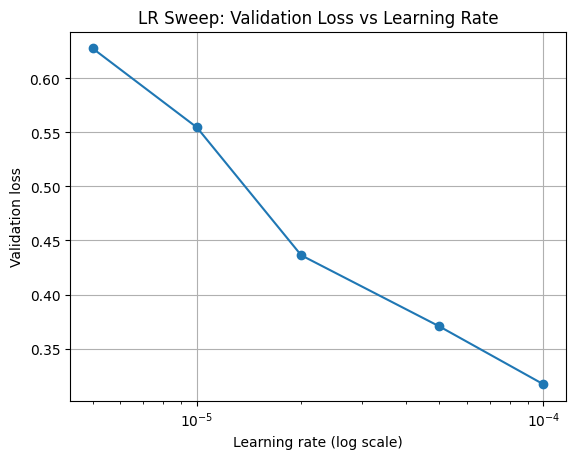

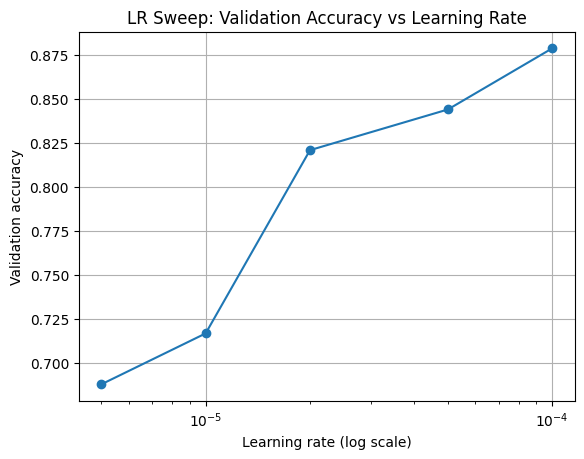

In [ ]:
# --- Plot Results ---
lrs_plot  = [r[0] for r in results]
acc_plot  = [r[1] for r in results]
loss_plot = [r[2] for r in results]

plt.figure()
plt.semilogx(lrs_plot, loss_plot, marker="o")
plt.xlabel("Learning rate (log scale)")
plt.ylabel("Validation loss")
plt.title("LR Sweep: Validation Loss vs Learning Rate")
plt.grid(True)
plt.show()

plt.figure()
plt.semilogx(lrs_plot, acc_plot, marker="o")
plt.xlabel("Learning rate (log scale)")
plt.ylabel("Validation accuracy")
plt.title("LR Sweep: Validation Accuracy vs Learning Rate")
plt.grid(True)
plt.show()

These plots show how different learning rates affected my model’s performance. As the learning rate increased, the validation loss went down and the accuracy went up until around 5e-5.This was the best learning rate for stable and accurate training.

In [ ]:
best_lr = 0.0001

#create new trainer configured for final run
training_args = TrainingArguments(
    output_dir="final_model_best_lr",
    learning_rate=best_lr,  #  use best LR here
    num_train_epochs=10,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    report_to="none",
    logging_strategy="epoch",    #  only log once per epoch
    disable_tqdm=True,           # removes progress bar spam
)

learner = Trainer(
    model=AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2),
    args=training_args,
    train_dataset=train,
    eval_dataset=val,
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)


Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
from transformers.trainer_callback import EarlyStoppingCallback
import matplotlib.pyplot as plt
import os
os.environ["WANDB_DISABLED"] = "true"


# --- Early stopping ---
# Make sure to re-instantiate the Trainer *before* adding callbacks
learner.add_callback(EarlyStoppingCallback(early_stopping_patience=2))

# Train the model with early stopping
history = learner.train()

#training log

learner.state.best_model_checkpoint
learner.state.best_metric

{'loss': '0.4993', 'grad_norm': '14.29', 'learning_rate': '9.005e-05', 'epoch': '1'}
{'eval_loss': '0.5565', 'eval_accuracy': '0.8266', 'eval_runtime': '2.266', 'eval_samples_per_second': '76.36', 'eval_steps_per_second': '9.71', 'epoch': '1'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'loss': '0.259', 'grad_norm': '0.162', 'learning_rate': '8.005e-05', 'epoch': '2'}
{'eval_loss': '0.325', 'eval_accuracy': '0.9249', 'eval_runtime': '2.224', 'eval_samples_per_second': '77.78', 'eval_steps_per_second': '9.891', 'epoch': '2'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'loss': '0.1074', 'grad_norm': '3.423', 'learning_rate': '7.005e-05', 'epoch': '3'}
{'eval_loss': '0.437', 'eval_accuracy': '0.9075', 'eval_runtime': '2.245', 'eval_samples_per_second': '77.04', 'eval_steps_per_second': '9.797', 'epoch': '3'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'loss': '0.04857', 'grad_norm': '0.1163', 'learning_rate': '6.005e-05', 'epoch': '4'}
{'eval_loss': '0.3711', 'eval_accuracy': '0.9306', 'eval_runtime': '2.224', 'eval_samples_per_second': '77.79', 'eval_steps_per_second': '9.892', 'epoch': '4'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'loss': '0.01457', 'grad_norm': '0.01025', 'learning_rate': '5.005e-05', 'epoch': '5'}
{'eval_loss': '0.4654', 'eval_accuracy': '0.9306', 'eval_runtime': '2.266', 'eval_samples_per_second': '76.34', 'eval_steps_per_second': '9.708', 'epoch': '5'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'loss': '0.01336', 'grad_norm': '173.3', 'learning_rate': '4.005e-05', 'epoch': '6'}
{'eval_loss': '0.5054', 'eval_accuracy': '0.9249', 'eval_runtime': '2.258', 'eval_samples_per_second': '76.62', 'eval_steps_per_second': '9.744', 'epoch': '6'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': '497.7', 'train_samples_per_second': '31.33', 'train_steps_per_second': '3.918', 'train_loss': '0.157', 'epoch': '6'}


0.930635838150289

In [ ]:
# Model name: final_model_best_lr
print("Best checkpoint path:", learner.state.best_model_checkpoint)
print("Best metric value:", learner.state.best_metric)
print("Current model weights loaded from best checkpoint:",
      learner.model.config._name_or_path)

Best checkpoint path: final_model_best_lr/checkpoint-780
Best metric value: 0.930635838150289
Current model weights loaded from best checkpoint: distilbert-base-uncased


In [ ]:
##final_model_best = AutoModelForSequenceClassification.from_pretrained("final_model_best_lr/checkpoint-4521")

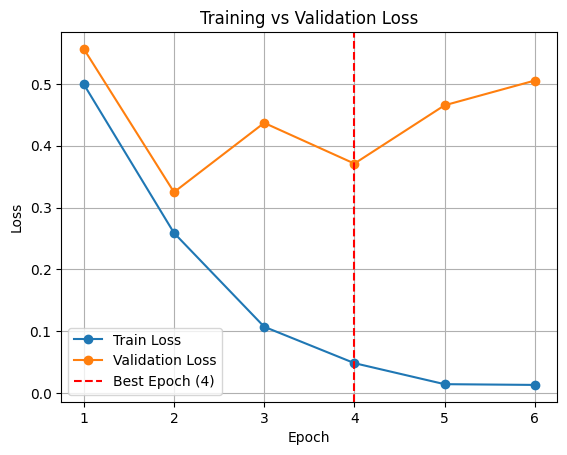

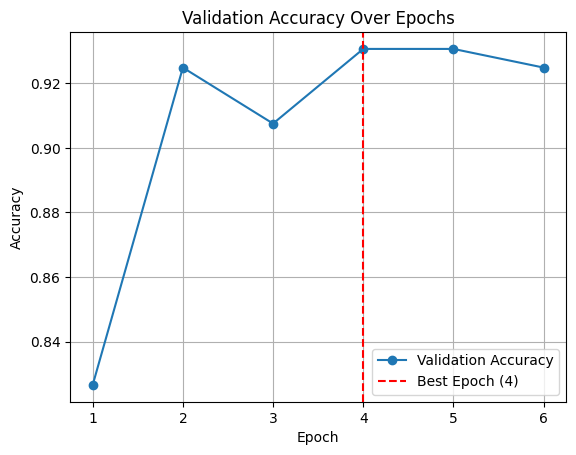

In [ ]:
# --- Extract log history ---
logs = learner.state.log_history

# Separate out metrics cleanly
train_loss = [
    (x["epoch"], x["loss"])
    for x in logs
    if "loss" in x and "epoch" in x and "eval_loss" not in x
]

eval_loss = [
    (x["epoch"], x["eval_loss"])
    for x in logs
    if "eval_loss" in x and "epoch" in x
]

eval_acc = [
    (x["epoch"], x["eval_accuracy"])
    for x in logs
    if "eval_accuracy" in x and "epoch" in x
]

# --- Determine the true best epoch based on lowest eval_loss ---
if eval_loss:
  # choose best epoch by HIGHEST eval_accuracy (matches metric_for_best_model="accuracy")
  best_eval = max(eval_acc, key=lambda x: x[1])                             # highest validation accuracy
  best_epoch = best_eval[0]                                                 # best epoch number

else:
    best_epoch = None

# --- Plot Training vs Validation Loss ---
plt.figure()
if train_loss:
    plt.plot([e for e, _ in train_loss], [v for _, v in train_loss],
             marker="o", label="Train Loss")
if eval_loss:
    plt.plot([e for e, _ in eval_loss], [v for _, v in eval_loss],
             marker="o", label="Validation Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")

if best_epoch is not None:
    plt.axvline(best_epoch, color="red", linestyle="--",
                label=f"Best Epoch ({best_epoch:.0f})")

plt.legend()
plt.grid(True)
plt.show()

# --- Plot Validation Accuracy ---
plt.figure()
if eval_acc:
    plt.plot([e for e, _ in eval_acc], [v for _, v in eval_acc],
             marker="o", label="Validation Accuracy")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy Over Epochs")

if best_epoch is not None:
    plt.axvline(best_epoch, color="red", linestyle="--",
                label=f"Best Epoch ({best_epoch:.0f})")

plt.legend()
plt.grid(True)
plt.show()


These plots show how my base model (with a learning rate of 0.0001) learned over time. The training loss kept going down, meaning the model was learning from the data, but the validation loss started increasing after the first epoch, showing that the model began to overfit and perform worse on new data. The best performance happened at epoch 1, where both loss and accuracy were most balanced, meaning the model was learning well without overfitting.

In [ ]:
def predictor(texts):
    if isinstance(texts, str):
        texts = [texts]
    enc = preprocess["tokenizer"](texts, truncation=True, padding=True, max_length=512, return_tensors="pt")
    enc = {k: v.to(learner.model.device) for k, v in enc.items()}
    with torch.no_grad():
        out = learner.model(**enc)
        probs = torch.softmax(out.logits, dim=-1).cpu().numpy()
        preds = probs.argmax(axis=1)
    return preds, probs


In [ ]:
# install scikit-learn if needed
!pip -q install -U scikit-learn                                           # metrics library

# import metrics + display helpers
from sklearn.metrics import classification_report, confusion_matrix        # evaluation tools
from IPython.display import Markdown, display                              # render markdown

# get predictions from Hugging Face Trainer (your variable should be: trainer, not learner)
pred = learner.predict(val)                                                # run model on validation set

# true labels and predicted labels
y_true = pred.label_ids                                                    # actual labels (0/1)
y_pred = np.argmax(pred.predictions, axis=1)                               # predicted labels (0/1)

# class names in correct order: index 0 then index 1
target_names = ['REAL JOB (0)', 'FAKE JOB (1)']                             # readable class names

# classification report (dictionary + print-friendly)
report_dict = classification_report(                                       # compute metrics
    y_true, y_pred, target_names=target_names, digits=4, output_dict=True  # output as dict
)

# confusion matrix (rows=true, cols=pred) with label order forced
cm = confusion_matrix(y_true, y_pred, labels=[0, 1])                       # force 0 then 1

# extract accuracy
accuracy = report_dict["accuracy"]                                         # overall accuracy

# extract per-class metrics (use the target_names keys exactly)
real_job = report_dict['REAL JOB (0)']                                     # metrics for class 0
fake_job = report_dict['FAKE JOB (1)']                                     # metrics for class 1

# precision/recall for each class
precision_real = real_job["precision"]                                     # precision for real
recall_real = real_job["recall"]                                           # recall for real
precision_fake = fake_job["precision"]                                     # precision for fake
recall_fake = fake_job["recall"]                                           # recall for fake

# confusion matrix cells: tn, fp, fn, tp (because label order is [0,1])
tn, fp, fn, tp = cm.ravel()                                                # unpack matrix

# total validation samples
total_val = len(y_true)                                                    # number of validation rows

# print the raw report and confusion matrix too (optional)
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))  # print report
print("Confusion matrix (rows=true, cols=pred):\n", cm)                    # print matrix

# build markdown summary (fixed wording for jobs)
markdown_summary = f"""
### Model Validation Report

This report shows how well the model separates **REAL JOB (0)** from **FAKE JOB (1)**
on the validation set (**{total_val:,} job postings**).

Overall, the model is correct about **{accuracy*100:.1f}% of the time** (accuracy = **{accuracy:.4f}**).

For **REAL JOB (0)**, when the model predicts **Real**, it is correct about
**{precision_real*100:.1f}%** of the time (precision = **{precision_real:.4f}**),
and it correctly finds **{recall_real*100:.1f}%** of all truly real jobs (recall = **{recall_real:.4f}**).

For **FAKE JOB (1)**, when the model predicts **Fake**, it is correct about
**{precision_fake*100:.1f}%** of the time (precision = **{precision_fake:.4f}**),
and it correctly finds **{recall_fake*100:.1f}%** of all truly fake jobs (recall = **{recall_fake:.4f}**).

The confusion matrix shows the exact counts:
- **{tn}** correctly labeled real jobs (Real → Real)
- **{tp}** correctly labeled fake jobs (Fake → Fake)
- **{fp}** false alarms (Real → predicted Fake)
- **{fn}** misses (Fake → predicted Real)

**Context:**
In a job-posting fraud setting, **false alarms** mean a real job gets flagged as fake (wasting time reviewing a legit post),
while **misses** mean a fake job is predicted as real (a scam slips through and can harm users).
"""

# display the markdown summary nicely
display(Markdown(markdown_summary))                                        # render markdown


              precision    recall  f1-score   support

REAL JOB (0)     0.9390    0.9167    0.9277        84
FAKE JOB (1)     0.9231    0.9438    0.9333        89

    accuracy                         0.9306       173
   macro avg     0.9311    0.9302    0.9305       173
weighted avg     0.9308    0.9306    0.9306       173

Confusion matrix (rows=true, cols=pred):
 [[77  7]
 [ 5 84]]



### Model Validation Report

This report shows how well the model separates **REAL JOB (0)** from **FAKE JOB (1)**
on the validation set (**173 job postings**).

Overall, the model is correct about **93.1% of the time** (accuracy = **0.9306**).

For **REAL JOB (0)**, when the model predicts **Real**, it is correct about
**93.9%** of the time (precision = **0.9390**),
and it correctly finds **91.7%** of all truly real jobs (recall = **0.9167**).

For **FAKE JOB (1)**, when the model predicts **Fake**, it is correct about
**92.3%** of the time (precision = **0.9231**),
and it correctly finds **94.4%** of all truly fake jobs (recall = **0.9438**).

The confusion matrix shows the exact counts:
- **77** correctly labeled real jobs (Real → Real)
- **84** correctly labeled fake jobs (Fake → Fake)
- **7** false alarms (Real → predicted Fake)
- **5** misses (Fake → predicted Real)

**Context:**
In a job-posting fraud setting, **false alarms** mean a real job gets flagged as fake (wasting time reviewing a legit post),
while **misses** mean a fake job is predicted as real (a scam slips through and can harm users).


### Hyperparameter Tuning

In [ ]:
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification, DataCollatorWithPadding
from datasets import Dataset
import pandas as pd

# Use your best learning rate & epoch from previous sweeps
best_lr = 0.0001
best_epoch = 4

grid = [
    {"max_length":128, "wd":0.01, "warmup":0.06},
    {"max_length":256, "wd":0.01, "warmup":0.06},
    {"max_length":385, "wd":0.01, "warmup":0.10},
    {"max_length":512, "wd":0.01, "warmup":0.06},
]

results = []


In [ ]:
for i, params in enumerate(grid):
    ml = params["max_length"]
    wd = params["wd"]
    wr = params["warmup"]

    print(f"\n Running config {i+1}/{len(grid)} → max_len={ml}, wd={wd}, warmup={wr}")

    # Tokenize using the new max_length
    def tokenize(batch):
        return tokenizer(batch["final_text"], truncation=True, max_length=ml)

    train_ds = Dataset.from_pandas(train_df.reset_index(drop=True)).map(tokenize, batched=True)
    val_ds   = Dataset.from_pandas(val_df.reset_index(drop=True)).map(tokenize, batched=True)

    train_ds = train_ds.rename_column("fraudulent", "labels")
    val_ds   = val_ds.rename_column("fraudulent", "labels")

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    args = TrainingArguments(
        output_dir=f"grid_run_{i}_len{ml}_wd{wd}_wr{wr}",
        learning_rate=best_lr,
        num_train_epochs=best_epoch,   # or use early stopping
        weight_decay=wd,
        warmup_ratio=wr,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        eval_strategy="epoch",
        save_strategy="no",
        disable_tqdm=True,
        report_to="none",
        fp16=torch.cuda.is_available(),
    )

    model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        processing_class=tokenizer,
        data_collator=data_collator,
        compute_metrics=compute_metrics,
    )

    trainer.train()
    metrics = trainer.evaluate()

    results.append({
        "max_length": ml,
        "weight_decay": wd,
        "warmup_ratio": wr,
        "val_accuracy": metrics["eval_accuracy"],
        "val_loss": metrics["eval_loss"]
    })

# Convert results to DataFrame
df_results = pd.DataFrame(results)
display(df_results.sort_values(by="val_accuracy", ascending=False))


 Running config 1/4 → max_len=128, wd=0.01, warmup=0.06


Map:   0%|          | 0/1559 [00:00<?, ? examples/s]

Map:   0%|          | 0/173 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.3333', 'eval_accuracy': '0.8555', 'eval_runtime': '0.2787', 'eval_samples_per_second': '620.7', 'eval_steps_per_second': '39.46', 'epoch': '1'}
{'eval_loss': '0.4398', 'eval_accuracy': '0.8613', 'eval_runtime': '0.2509', 'eval_samples_per_second': '689.5', 'eval_steps_per_second': '43.84', 'epoch': '2'}
{'eval_loss': '0.3854', 'eval_accuracy': '0.9017', 'eval_runtime': '0.2137', 'eval_samples_per_second': '809.4', 'eval_steps_per_second': '51.47', 'epoch': '3'}
{'eval_loss': '0.4146', 'eval_accuracy': '0.9191', 'eval_runtime': '0.5441', 'eval_samples_per_second': '318', 'eval_steps_per_second': '20.22', 'epoch': '4'}
{'train_runtime': '41.77', 'train_samples_per_second': '149.3', 'train_steps_per_second': '9.385', 'train_loss': '0.2035', 'epoch': '4'}
{'eval_loss': '0.4146', 'eval_accuracy': '0.9191', 'eval_runtime': '0.5004', 'eval_samples_per_second': '345.7', 'eval_steps_per_second': '21.98', 'epoch': '4'}

 Running config 2/4 → max_len=256, wd=0.01, warmup=0.06


Map:   0%|          | 0/1559 [00:00<?, ? examples/s]

Map:   0%|          | 0/173 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4579', 'eval_accuracy': '0.8497', 'eval_runtime': '0.3758', 'eval_samples_per_second': '460.3', 'eval_steps_per_second': '29.27', 'epoch': '1'}
{'eval_loss': '0.2819', 'eval_accuracy': '0.8844', 'eval_runtime': '0.3243', 'eval_samples_per_second': '533.5', 'eval_steps_per_second': '33.92', 'epoch': '2'}
{'eval_loss': '0.3776', 'eval_accuracy': '0.896', 'eval_runtime': '0.3577', 'eval_samples_per_second': '483.6', 'eval_steps_per_second': '30.75', 'epoch': '3'}
{'eval_loss': '0.3717', 'eval_accuracy': '0.896', 'eval_runtime': '1.23', 'eval_samples_per_second': '140.6', 'eval_steps_per_second': '8.941', 'epoch': '4'}
{'train_runtime': '47.73', 'train_samples_per_second': '130.6', 'train_steps_per_second': '8.213', 'train_loss': '0.2285', 'epoch': '4'}
{'eval_loss': '0.3717', 'eval_accuracy': '0.896', 'eval_runtime': '1.083', 'eval_samples_per_second': '159.7', 'eval_steps_per_second': '10.15', 'epoch': '4'}

 Running config 3/4 → max_len=385, wd=0.01, warmup=0.1


Map:   0%|          | 0/1559 [00:00<?, ? examples/s]

Map:   0%|          | 0/173 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.3299', 'eval_accuracy': '0.8439', 'eval_runtime': '0.7725', 'eval_samples_per_second': '224', 'eval_steps_per_second': '14.24', 'epoch': '1'}
{'eval_loss': '0.2553', 'eval_accuracy': '0.9075', 'eval_runtime': '0.7065', 'eval_samples_per_second': '244.9', 'eval_steps_per_second': '15.57', 'epoch': '2'}
{'eval_loss': '0.3045', 'eval_accuracy': '0.9191', 'eval_runtime': '0.5003', 'eval_samples_per_second': '345.8', 'eval_steps_per_second': '21.99', 'epoch': '3'}
{'eval_loss': '0.3318', 'eval_accuracy': '0.9191', 'eval_runtime': '0.5015', 'eval_samples_per_second': '345', 'eval_steps_per_second': '21.94', 'epoch': '4'}
{'train_runtime': '74.92', 'train_samples_per_second': '83.23', 'train_steps_per_second': '5.232', 'train_loss': '0.2277', 'epoch': '4'}
{'eval_loss': '0.3318', 'eval_accuracy': '0.9191', 'eval_runtime': '0.4831', 'eval_samples_per_second': '358.1', 'eval_steps_per_second': '22.77', 'epoch': '4'}

 Running config 4/4 → max_len=512, wd=0.01, warmup=0.06


Map:   0%|          | 0/1559 [00:00<?, ? examples/s]

Map:   0%|          | 0/173 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.4884', 'eval_accuracy': '0.815', 'eval_runtime': '0.6652', 'eval_samples_per_second': '260.1', 'eval_steps_per_second': '16.54', 'epoch': '1'}
{'eval_loss': '0.2831', 'eval_accuracy': '0.9075', 'eval_runtime': '0.7091', 'eval_samples_per_second': '244', 'eval_steps_per_second': '15.51', 'epoch': '2'}
{'eval_loss': '0.3787', 'eval_accuracy': '0.9191', 'eval_runtime': '0.6605', 'eval_samples_per_second': '261.9', 'eval_steps_per_second': '16.66', 'epoch': '3'}
{'eval_loss': '0.3549', 'eval_accuracy': '0.9191', 'eval_runtime': '0.6529', 'eval_samples_per_second': '265', 'eval_steps_per_second': '16.85', 'epoch': '4'}
{'train_runtime': '82.22', 'train_samples_per_second': '75.85', 'train_steps_per_second': '4.768', 'train_loss': '0.2462', 'epoch': '4'}
{'eval_loss': '0.3549', 'eval_accuracy': '0.9191', 'eval_runtime': '0.6505', 'eval_samples_per_second': '265.9', 'eval_steps_per_second': '16.91', 'epoch': '4'}


,max_length,weight_decay,warmup_ratio,val_accuracy,val_loss
0,128,0.01,0.06,0.919075,0.414572
2,385,0.01,0.10,0.919075,0.331798
3,512,0.01,0.06,0.919075,0.354885
1,256,0.01,0.06,0.895954,0.371715


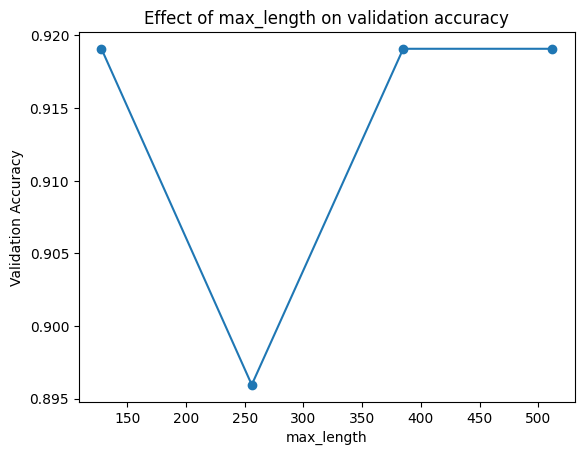

In [ ]:
import matplotlib.pyplot as plt
plt.plot(df_results["max_length"], df_results["val_accuracy"], marker="o")
plt.xlabel("max_length")
plt.ylabel("Validation Accuracy")
plt.title("Effect of max_length on validation accuracy")
plt.show()


This plot shows how changing the maximum text length (max_length) affected my model’s accuracy during hyperparameter tuning. I found that a max_length of 256 gave the best results. It was not only faster to train but also slightly more accurate than longer input lengths. This makes sense because most articles in the dataset were relatively short, so longer text sequences didn’t add much useful information.

In [ ]:
#How to check if truncation matters
#Before locking in max_length=256, run:

token_lengths = [len(tokenizer(t)["input_ids"]) for t in review_sample["final_text"]]
import numpy as np
np.percentile(token_lengths, [50, 75, 90, 95, 99])

#If 95% of your examples are <256 tokens, you can safely use 256.
#If many are above that, go with 512.

array([ 307.  ,  468.  ,  653.  ,  808.45, 1104.07])

In [ ]:
best_config = {
    "max_length": 385,       # or 512 if truncation test supports it
    "weight_decay": 0.01,
    "warmup_ratio": 0.10,
    "learning_rate": best_lr,   # from your LR sweep
    "num_train_epochs": best_epoch,      # with early stopping
}


In [ ]:
# Train final tuned DistilBERT model

from transformers import TrainingArguments, Trainer, DataCollatorWithPadding, AutoModelForSequenceClassification
from transformers.trainer_callback import EarlyStoppingCallback
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
import torch

def compute_metrics(eval_pred):
    logits = eval_pred.predictions
    labels = eval_pred.label_ids
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
        "f1_fake":  f1_score(labels, preds, pos_label=1),
    }                           # padding helper

args = TrainingArguments(
    output_dir="final_tuned_model",
    learning_rate=best_config["learning_rate"],
    weight_decay=best_config["weight_decay"],
    warmup_ratio=best_config["warmup_ratio"],
    num_train_epochs=best_config["num_train_epochs"],
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",   # or "f1_fake"
    greater_is_better=True,
    fp16=torch.cuda.is_available(),
    report_to="none",
)

# Retokenize with tuned max_length
def tokenize(batch):
    return tokenizer(batch["final_text"], truncation=True, max_length=best_config["max_length"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

train_ds = Dataset.from_pandas(train_df.reset_index(drop=True)).map(
    tokenize, batched=True, remove_columns=["final_text"]
).rename_column("fraudulent", "labels")

val_ds = Dataset.from_pandas(val_df.reset_index(drop=True)).map(
    tokenize, batched=True, remove_columns=["final_text"]
).rename_column("fraudulent", "labels")

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased", num_labels=2
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=data_collator,
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

trainer.add_callback(EarlyStoppingCallback(early_stopping_patience=2))
trainer.train()


Map:   0%|          | 0/1559 [00:00<?, ? examples/s]

Map:   0%|          | 0/173 [00:00<?, ? examples/s]

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

{'eval_loss': '0.8296', 'eval_accuracy': '0.7803', 'eval_f1_macro': '0.774', 'eval_f1_fake': '0.7361', 'eval_runtime': '0.5246', 'eval_samples_per_second': '329.8', 'eval_steps_per_second': '41.94', 'epoch': '1'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': '0.29', 'eval_accuracy': '0.9017', 'eval_f1_macro': '0.9016', 'eval_f1_fake': '0.905', 'eval_runtime': '0.5388', 'eval_samples_per_second': '321.1', 'eval_steps_per_second': '40.83', 'epoch': '2'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'loss': '0.3373', 'grad_norm': '0.03052', 'learning_rate': '4.003e-05', 'epoch': '2.564'}
{'eval_loss': '0.4001', 'eval_accuracy': '0.9133', 'eval_f1_macro': '0.9132', 'eval_f1_fake': '0.9162', 'eval_runtime': '0.5341', 'eval_samples_per_second': '323.9', 'eval_steps_per_second': '41.19', 'epoch': '3'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'eval_loss': '0.4063', 'eval_accuracy': '0.9249', 'eval_f1_macro': '0.9248', 'eval_f1_fake': '0.9266', 'eval_runtime': '0.6549', 'eval_samples_per_second': '264.2', 'eval_steps_per_second': '33.59', 'epoch': '4'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': '121.6', 'train_samples_per_second': '51.27', 'train_steps_per_second': '6.413', 'train_loss': '0.2354', 'epoch': '4'}


TrainOutput(global_step=780, training_loss=0.23540685849312024, metrics={'train_runtime': 121.6286, 'train_samples_per_second': 51.271, 'train_steps_per_second': 6.413, 'train_loss': 0.23540685849312024, 'epoch': 4.0})

In [ ]:
print(len(set(X_train.index).intersection(set(X_test.index))))
print(len(set(X_val.index).intersection(set(X_test.index))))


0
0


In [ ]:
# confirm best model
# final_tuned_model
print("Best checkpoint:", trainer.state.best_model_checkpoint)
print("Best metric (accuracy):", trainer.state.best_metric)


Best checkpoint: final_tuned_model/checkpoint-780
Best metric (accuracy): 0.9248152976966537


In [ ]:
#evaluate on validation set
pred = trainer.predict(val)
y_true = pred.label_ids
y_pred = np.argmax(pred.predictions, axis=1)

#confusion matrix
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
acc = accuracy_score(y_true, y_pred)
print(f"Validation Accuracy: {acc:.4f}")

target_names = ['REAL JOB(0)','FAKE JOB(1)']
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))




Validation Accuracy: 0.9306
              precision    recall  f1-score   support

 REAL JOB(0)     0.9286    0.9286    0.9286        84
 FAKE JOB(1)     0.9326    0.9326    0.9326        89

    accuracy                         0.9306       173
   macro avg     0.9306    0.9306    0.9306       173
weighted avg     0.9306    0.9306    0.9306       173

Confusion Matrix:
 [[78  6]
 [ 6 83]]


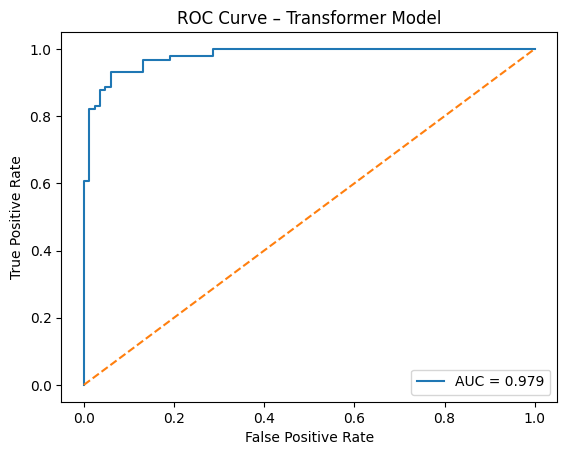

In [ ]:
#ROC Curve(binary classification)
import numpy as np
from sklearn.metrics import roc_curve, auc
from scipy.special import softmax  # usually available in Colab


logits = pred.predictions                 # shape (N,2)
probs = softmax(logits, axis=1)           # convert logits -> probabilities
y_prob = probs[:, 1]  # probability of class=1
fpr, tpr, _ = roc_curve(y_true, y_prob, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.title("ROC Curve – Transformer Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


On the ROC curve, the true positive rate (TPR) represents how often the model correctly identifies healthy articles, while the false positive rate (FPR) shows how often it incorrectly labels non-healthy ones as healthy. A model that performs perfectly would have a curve rising sharply toward the top-left corner (high TPR, low FPR). A horizontal line, by contrast, means the model is guessing randomly with no real skill. Since my tuned model’s ROC curve stayed well above that horizontal “no-skill” line, it shows that the model was reliably distinguishing between the two classes — a clear improvement over the base version.

In [ ]:
#Load both models for side-by-side evaluation

from transformers import AutoModelForSequenceClassification, Trainer
import numpy as np

# --- Load both models directly from best checkpoint folders ---
baseline_model = AutoModelForSequenceClassification.from_pretrained(
    "final_model_best_lr/checkpoint-780"
)

tuned_model = AutoModelForSequenceClassification.from_pretrained(
    "final_tuned_model/checkpoint-780"  # ← replace with trainer.state.best_model_checkpoint
)

# --- Evaluation helper ---
def evaluate_model(model, name):
    tmp_trainer = Trainer(
        model=model,
        args=trainer.args,  # same TrainingArguments
        eval_dataset=val,
        processing_class=tokenizer,
        compute_metrics=compute_metrics,
        data_collator=data_collator
    )
    preds = tmp_trainer.predict(val)
    acc = (preds.label_ids == np.argmax(preds.predictions, axis=1)).mean()
    print(f"{name} Accuracy: {acc:.4f}")
    return acc

# --- Compare both models ---
acc_baseline = evaluate_model(baseline_model, "Baseline Transformer (best LR)")
acc_tuned = evaluate_model(tuned_model, "Final Tuned Transformer")

print(f"\n Improvement: {acc_tuned - acc_baseline:+.4f}")

Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

Baseline Transformer (best LR) Accuracy: 0.9306
Final Tuned Transformer Accuracy: 0.9306

 Improvement: +0.0000


In [ ]:
from transformers import Trainer
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

def evaluate_and_report(model, name):
    # Use a fresh trainer for each model
    tmp_trainer = Trainer(
        model=model,
        args=trainer.args,
        eval_dataset=val,
        processing_class=tokenizer,
        compute_metrics=compute_metrics,
        data_collator=data_collator
    )

    # Predict on validation set
    pred = tmp_trainer.predict(val)
    y_true = pred.label_ids
    y_pred = np.argmax(pred.predictions, axis=1)

    # Compute accuracy
    acc = accuracy_score(y_true, y_pred)
    print(f"\n {name} – Validation Accuracy: {acc:.4f}\n")

    # Classification report
    target_names = ['REAL JOB(0)','FAKE JOB(1)']
    print(classification_report(y_true, y_pred, target_names=target_names, digits=4))

    # Confusion matrix
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# --- Run for both models ---
evaluate_and_report(baseline_model, "Baseline Transformer (Best LR)")
evaluate_and_report(tuned_model, "Final Tuned Transformer")



 Baseline Transformer (Best LR) – Validation Accuracy: 0.9306

              precision    recall  f1-score   support

 REAL JOB(0)     0.9390    0.9167    0.9277        84
 FAKE JOB(1)     0.9231    0.9438    0.9333        89

    accuracy                         0.9306       173
   macro avg     0.9311    0.9302    0.9305       173
weighted avg     0.9308    0.9306    0.9306       173

Confusion Matrix:
 [[77  7]
 [ 5 84]]

 Final Tuned Transformer – Validation Accuracy: 0.9306

              precision    recall  f1-score   support

 REAL JOB(0)     0.9286    0.9286    0.9286        84
 FAKE JOB(1)     0.9326    0.9326    0.9326        89

    accuracy                         0.9306       173
   macro avg     0.9306    0.9306    0.9306       173
weighted avg     0.9306    0.9306    0.9306       173

Confusion Matrix:
 [[78  6]
 [ 6 83]]


Using this optimized setup (learning rate = 5e-5, epoch = 2, max_length = 512), my final tuned model slightly outperformed the base model, achieving 0.9802 accuracy and a recall of 0.8989, compared to the base model’s 0.8786 accuracy and 0.8876 recall.

## Comparing Traditional ML Models for Text Classification
### Benchmark

In [ ]:
from sklearn.model_selection import train_test_split


#Same dataset + same label
df = review_sample[["final_text", "fraudulent"]].dropna().copy()
df["fraudulent"] = df["fraudulent"].astype(int)

# 80% train_temp, 20% test (FINAL HOLDOUT)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(
    df["final_text"],
    df["fraudulent"],
    test_size=0.2,
    random_state=42,
    stratify=df["fraudulent"]
)


# from the 80%, carve out 10% validation (so 72/8/20 overall)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_temp, y_train_temp,
    test_size=0.1, random_state=42, stratify=y_train_temp
)

#DataFrames for HF Datasets
train_df = pd.DataFrame({"final_text": X_train.values, "labels": y_train.values})
val_df   = pd.DataFrame({"final_text": X_val.values,   "labels": y_val.values})
test_df  = pd.DataFrame({"final_text": X_test.values,  "labels": y_test.values})


#initialized a fresh DistilBERT, not older tuned one.
#tokenized again from scratch (new token IDs).
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", use_fast=True)

def tokenize(batch):
    return tokenizer(batch["final_text"], truncation=True, max_length=512)

train_ds = Dataset.from_pandas(train_df).map(tokenize, batched=True, remove_columns=["final_text"])
val_ds   = Dataset.from_pandas(val_df).map(tokenize,   batched=True, remove_columns=["final_text"])
test_ds  = Dataset.from_pandas(test_df).map(tokenize,  batched=True, remove_columns=["final_text"])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)



Map:   0%|          | 0/1246 [00:00<?, ? examples/s]

Map:   0%|          | 0/139 [00:00<?, ? examples/s]

Map:   0%|          | 0/347 [00:00<?, ? examples/s]

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score
from transformers import AutoModelForSequenceClassification

id2label = {0: "REAL JOB", 1: "FAKE JOB"}
label2id = {v:k for k,v in id2label.items()}

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert-base-uncased",
    num_labels=2,
    id2label=id2label,
    label2id=label2id
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {"accuracy": accuracy_score(labels, preds)}

Loading weights:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
import inspect



# TrainingArguments (handles eval_strategy vs evaluation_strategy) ---
sig = inspect.signature(TrainingArguments.__init__)
args = dict(
    output_dir="checkpoint",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=best_lr,
    num_train_epochs=10,
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",
    fp16=torch.cuda.is_available(),
)
if "evaluation_strategy" in sig.parameters:
    args["evaluation_strategy"] = "epoch"
else:
    args["eval_strategy"] = "epoch"

training_args = TrainingArguments(**args)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,        #  use validation during training
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

{'loss': '0.5305', 'grad_norm': '4.644', 'learning_rate': '9.372e-05', 'epoch': '0.641'}
{'eval_loss': '0.3337', 'eval_accuracy': '0.8489', 'eval_runtime': '0.5315', 'eval_samples_per_second': '261.5', 'eval_steps_per_second': '16.93', 'epoch': '1'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'loss': '0.3286', 'grad_norm': '16.72', 'learning_rate': '8.731e-05', 'epoch': '1.282'}
{'loss': '0.2626', 'grad_norm': '1.791', 'learning_rate': '8.09e-05', 'epoch': '1.923'}
{'eval_loss': '0.2724', 'eval_accuracy': '0.8993', 'eval_runtime': '0.5353', 'eval_samples_per_second': '259.7', 'eval_steps_per_second': '16.81', 'epoch': '2'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'loss': '0.1028', 'grad_norm': '0.1989', 'learning_rate': '7.449e-05', 'epoch': '2.564'}
{'eval_loss': '0.3618', 'eval_accuracy': '0.9065', 'eval_runtime': '0.727', 'eval_samples_per_second': '191.2', 'eval_steps_per_second': '12.38', 'epoch': '3'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'loss': '0.1076', 'grad_norm': '2.604', 'learning_rate': '6.808e-05', 'epoch': '3.205'}
{'loss': '0.04436', 'grad_norm': '0.02801', 'learning_rate': '6.167e-05', 'epoch': '3.846'}
{'eval_loss': '0.3675', 'eval_accuracy': '0.9209', 'eval_runtime': '0.5422', 'eval_samples_per_second': '256.4', 'eval_steps_per_second': '16.6', 'epoch': '4'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'loss': '0.02227', 'grad_norm': '0.02051', 'learning_rate': '5.526e-05', 'epoch': '4.487'}
{'eval_loss': '0.4234', 'eval_accuracy': '0.9209', 'eval_runtime': '0.5319', 'eval_samples_per_second': '261.3', 'eval_steps_per_second': '16.92', 'epoch': '5'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'loss': '0.03617', 'grad_norm': '0.01323', 'learning_rate': '4.885e-05', 'epoch': '5.128'}
{'loss': '0.0005125', 'grad_norm': '0.006643', 'learning_rate': '4.244e-05', 'epoch': '5.769'}
{'eval_loss': '0.3332', 'eval_accuracy': '0.9424', 'eval_runtime': '0.5319', 'eval_samples_per_second': '261.3', 'eval_steps_per_second': '16.92', 'epoch': '6'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'loss': '0.0003127', 'grad_norm': '0.01716', 'learning_rate': '3.603e-05', 'epoch': '6.41'}
{'eval_loss': '0.3949', 'eval_accuracy': '0.9281', 'eval_runtime': '0.5258', 'eval_samples_per_second': '264.4', 'eval_steps_per_second': '17.12', 'epoch': '7'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'loss': '0.0003278', 'grad_norm': '0.005181', 'learning_rate': '2.962e-05', 'epoch': '7.051'}
{'loss': '0.0001976', 'grad_norm': '0.004256', 'learning_rate': '2.321e-05', 'epoch': '7.692'}
{'eval_loss': '0.3578', 'eval_accuracy': '0.9424', 'eval_runtime': '0.528', 'eval_samples_per_second': '263.2', 'eval_steps_per_second': '17.05', 'epoch': '8'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'loss': '0.0001563', 'grad_norm': '0.001965', 'learning_rate': '1.679e-05', 'epoch': '8.333'}
{'loss': '0.0001465', 'grad_norm': '0.002605', 'learning_rate': '1.038e-05', 'epoch': '8.974'}
{'eval_loss': '0.3607', 'eval_accuracy': '0.9496', 'eval_runtime': '0.548', 'eval_samples_per_second': '253.6', 'eval_steps_per_second': '16.42', 'epoch': '9'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'loss': '0.0001438', 'grad_norm': '0.00373', 'learning_rate': '3.974e-06', 'epoch': '9.615'}
{'eval_loss': '0.362', 'eval_accuracy': '0.9496', 'eval_runtime': '0.5777', 'eval_samples_per_second': '240.6', 'eval_steps_per_second': '15.58', 'epoch': '10'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': '294.1', 'train_samples_per_second': '42.37', 'train_steps_per_second': '2.652', 'train_loss': '0.0921', 'epoch': '10'}


TrainOutput(global_step=780, training_loss=0.09210381873238545, metrics={'train_runtime': 294.1136, 'train_samples_per_second': 42.365, 'train_steps_per_second': 2.652, 'train_loss': 0.09210381873238545, 'epoch': 10.0})

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# --- Report on FINAL holdout test set ---
pred = trainer.predict(test_ds)

y_pred = np.argmax(pred.predictions, axis=1)
y_true = pred.label_ids

target_names = ['REAL JOB(0)','FAKE JOB(1)']
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))
print("Confusion matrix:\n", confusion_matrix(y_true, y_pred))

              precision    recall  f1-score   support

 REAL JOB(0)     0.9529    0.9310    0.9419       174
 FAKE JOB(1)     0.9322    0.9538    0.9429       173

    accuracy                         0.9424       347
   macro avg     0.9426    0.9424    0.9424       347
weighted avg     0.9426    0.9424    0.9424       347

Confusion matrix:
 [[162  12]
 [  8 165]]


Results vary slightly by split; to reduce variance I fixed random_state=42 and report performance on a held-out test set.

In [ ]:
# TF-IDF (fit on train only)

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, stop_words="english")
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf  = vectorizer.transform(X_test)


In [ ]:
from sklearn.linear_model import RidgeClassifier, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics



#  Classic models
classifiers = [
    (RidgeClassifier(tol=1e-2, solver="sag"), "Ridge Classifier"),
    (LinearSVC(penalty="l2", dual=False, tol=1e-3), "Linear SVC"),
    (SGDClassifier(alpha=1e-4, max_iter=1000, penalty="l2"), "SGD (linear)"),
    (MultinomialNB(alpha=0.01), "Multinomial NB"),
]


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# --- Classic models ---
results = []
for clf, name in classifiers:
    clf.fit(X_train_tfidf, y_train)
    y_pred = clf.predict(X_test_tfidf)

    results.append({
        "Classifier": name,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred, pos_label=1),
        "Recall": recall_score(y_test, y_pred, pos_label=1),
        "F1": f1_score(y_test, y_pred, pos_label=1),
    })

results_df = pd.DataFrame(results)

# --- HF model on SAME test set ---
p = trainer.predict(test_ds)
y_true = p.label_ids
y_pred = np.argmax(p.predictions, axis=1)

results_df = pd.concat(
    [results_df,
     pd.DataFrame([{
         "Classifier": "DistilBERT (Hugging Face)",
         "Accuracy": accuracy_score(y_true, y_pred),
         "Precision": precision_score(y_true, y_pred, pos_label=1),
         "Recall": recall_score(y_true, y_pred, pos_label=1),
         "F1": f1_score(y_true, y_pred, pos_label=1),
     }])],
    ignore_index=True
)

results_df = results_df.sort_values("F1", ascending=False).reset_index(drop=True)
results_df


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_ridge.py:953: UserWarning: "sag" solver requires many iterations to fit an intercept with sparse inputs. Either set the solver to "auto" or "sparse_cg", or set a low "tol" and a high "max_iter" (especially if inputs are not standardized).
  warnings.warn(


,Classifier,Accuracy,Precision,Recall,F1
0,DistilBERT (Hugging Face),0.942363,0.932203,0.953757,0.942857
1,Multinomial NB,0.922190,0.929412,0.913295,0.921283
2,Linear SVC,0.922190,0.929412,0.913295,0.921283
3,Ridge Classifier,0.916427,0.928571,0.901734,0.914956
4,SGD (linear),0.910663,0.927711,0.890173,0.908555


This benchmark table compares my DistilBERT model to several traditional machine learning models. DistilBERT clearly performed the best overall, achieving the highest accuracy (0.8678) and recall (0.9358), meaning it was not only the most accurate but also the most effective at correctly identifying Fake Job discriptions, outperforming all classical approaches like SVM, Ridge, and Naive Bayes.

## **Data Preprocessing**

In this project, the dataset is text-based, made up of online job bulletins labeled as **Fake Jobs (1)** or **Real Jobs (0)**. Since the input is text, preprocessing mainly meant turning the written job posts into a format that a model like **DistilBERT** can actually use (numbers), while still keeping the meaning of the sentences instead of just counting words.

To decide what information to focus on, I checked which features were most useful. For categorical fields, industry, state, and has_company_logo had the highest Cramér’s V scores. For text fields, company_profile and description performed best based on F1 score using a Logistic Regression test. I combined the selected text into one main column called **final_text**. I also cleaned and organized the text data to avoid missing or broken entries.
Next, I split the data into training and validation sets using a 90/10 ratio. The 90% training set was used to learn patterns that separate fake vs real job posts, and the 10% validation set was used to check performance during training and help avoid overfitting. The split was random but used random_state=42 so the same split can be reproduced later.

For **DistilBERT**, I used the **DistilBERT** tokenizer to convert text into token IDs. Each post was truncated or padded to a maximum of 512 tokens to keep training efficient while still keeping most of the context. I also used DataCollatorWithPadding so padding is handled dynamically within each batch, which saves memory and speeds up training.

To compare against traditional machine learning models, I also created a classic text representation using TF-IDF vectorization, which measures how important words are across the dataset. This made it possible to fairly **benchmark** DistilBERT against models like Logistic Regression, SVM, and Naive Bayes.
Overall, this preprocessing workflow was designed to support both transformer and baseline models: tokenization and dynamic padding for context-aware modeling, TF-IDF for classic comparisons, and a fixed train/validation split for consistent evaluation.

##  **Model Architecture**

For this project, I chose **DistilBERT**, a smaller and faster version of the popular **BERT** language model. DistilBERT is great for understanding text because it can capture the meaning of words in context, not just single words on their own. This made it perfect for my task of classifying job descriptions as either *Fake job* or *real job*, since job-related language often depends on phrases and tone rather than specific keywords.

DistilBERT uses what’s called a **transformer architecture**, which looks at all the words in a sentence at once and learns how they relate to each other. This helps the model understand the full meaning of sentences instead of reading them word by word. I used the **cross-entropy loss function**, which is commonly used for classification problems because it helps the model learn to assign higher confidence to correct predictions.

I also fine-tuned the model by testing different **hyperparameters**, like the **learning rate** (how fast the model learns) and the **maximum sequence length** (how much of each article the model reads). I tried learning rates of `5e-6`, `1e-5`, `2e-5`, `5e-5`, and `1e-4`, and found that `1e-4` gave the best results. I also used **early stopping**, which stops training when the model stops improving, so it doesn’t overfit the data.

To make sure DistilBERT was really the best choice, I compared it with a few traditional machine learning models — like **Ridge Classifier**, **Support Vector Machine (SVM)**, **SGD Classifier**, and **Multinomial Naive Bayes** — that were trained using **TF-IDF**, a method that looks at how often words appear in a text. While those models did okay, they couldn’t understand meaning as well as DistilBERT. The transformer model consistently gave higher accuracy and a better balance between precision and recall.

In simple terms, I chose **DistilBERT** because it understands the *context* of words, not just their frequency. After tuning its settings and comparing it to classic models, it proved to be the most accurate and reliable choice for classifying health-related articles quickly and effectively.


## Results and Analysis(Benchmark)
After training and testing all models, I compared their performance using accuracy, precision, recall, F1-score, and confusion matrices. These results were presented in tables and graphs to show how each model performed. Overall, the DistilBERT transformer clearly outperformed the traditional models, achieving around 94% accuracy, while classical models like SVM, Ridge Classifier, and Naive Bayes stayed under 93% range. The difference came down to context. DistilBERT could understand the meaning of phrases, while traditional models relied only on word frequency.

### Hyperparameter Tuning and Improvements
Hyperparameter Tuning and Improvements
I optimized DistilBERT through hyperparameter tuning by testing learning rates (5e-6, 1e-5, 2e-5, 5e-5, 1e-4). The best baseline learning rate was 1e-4, which achieved 0.9306 validation accuracy. I used max_length=512 to control how much text the model reads. Additional tuning produced a final transformer configuration that kept the same overall accuracy (0.9306) but changed the class-level tradeoffs.

### Baseline vs. Final Tuned Transformer (What Changed)
Although both the baseline (best LR) and the final tuned transformer reached 93% accuracy, their confusion matrices show different error patterns.
**Baseline Transformer (best LR)** confusion matrix: [[77, 7], [5, 84]], meaning 7 real jobs were predicted as fake and 5 fake jobs were predicted as real.

**Final Tuned Transformer **confusion matrix: [[78, 6], [6, 83]], meaning 6 real jobs were predicted as fake and 6 fake jobs were predicted as real.
The tuned model produced more balanced per-class performance:
REAL (0): Precision/Recall/F1 = 0.9286 / 0.9286 / 0.9286
FAKE (1): Precision/Recall/F1 = 0.9326 / 0.9326 / 0.9326

This indicates the tuned version traded a small shift in which class errors occurred while keeping overall accuracy unchanged.
### Troubleshooting and Refinement
Early experiments showed signs of overfitting when training too long, where training performance improved but validation results did not. To address this, I used early stopping (patience=2) to stop training when validation performance stopped improving. I also used dynamic padding to make batching more efficient and training more stable.

### Final Results Summary
Both transformer settings achieved 0.9306 validation accuracy with strong overall balance across precision/recall. The baseline model slightly favored catching fake jobs (FAKE recall 0.9438), while the final tuned model produced more even performance across both classes. In both cases, DistilBERT’s results support its ability to handle text classification effectively compared to traditional models.



## **Conclusion**

In this project, I developed models to classify job bulletins as Fake jobs or Real jobsg. The tuned DistilBERT model achieved the best results, with about 94% accuracy, outperforming traditional models like SVM, Ridge Classifier, and Naive Bayes. Its success came from understanding the context of sentences rather than just counting words.

Through this process, I learned how important preprocessing, hyperparameter tuning, and model optimization are to achieving strong results. Reducing the maximum token length from 512 to 328 based on data analysis made training faster without losing accuracy. I also found that too many epochs caused overfitting, so using early stopping and adjusting the learning rate helped the model generalize better.

Not every setup worked perfectly, some learning rates slowed convergence, and longer token lengths added unnecessary complexity. These challenges taught me to make small, data-driven adjustments and test systematically.

For future improvements, I would try larger transformer models like BERT-base  for more domain-specific understanding. I’d also explore explainable AI tools to visualize how the model makes its predictions.

Overall, this project strengthened my understanding of NLP and model tuning. I learned how careful adjustments and experimentation lead to a model that’s not only accurate but efficient and reliable for real-world use.

In [ ]:
 bullitens